### Import libraries

In [239]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Reading Data

In [240]:
# Load data from different sheets of the Excel file
df1 = pd.read_excel('bitcoindata.xlsx', sheet_name='Bitcoin Data')
df2= pd.read_excel('bitcoindata.xlsx', sheet_name='Damage Estimates')



### Preparing Dataset

In [241]:
df1.isna().sum()

Unnamed: 0                          2193
Date                                   1
BTC price                              5
Network Hashrate (7-day average)       0
Rig Power Efficiency                   0
Power required                         0
Energy consumed per day                0
block time                             0
Reward                                 0
Energy per coin                        0
Coins created                          0
dtype: int64

In [242]:
df2.isna().sum()

Year                           3
Date                          10
Price                          2
Coins created                  2
kWh/coin                      10
GWh per day                    2
CO2e (kg/kWh)                 10
CO2e (tonnes/day)              2
CO2e (tonnes/coin)             2
damages $/coin                 2
damages $/value                2
total damages $ (millions)     2
dtype: int64

In [243]:
df1.drop("Unnamed: 0",axis=1,inplace=True)

In [244]:
df2.drop("Price",axis=1,inplace=True)

In [245]:
df1.dropna(inplace=True)

In [246]:
df2.dropna(inplace=True)

In [247]:
df1.shape

(2188, 10)

In [248]:
df2.shape

(2192, 11)

In [249]:
df1

,Date,BTC price,Network Hashrate (7-day average),Rig Power Efficiency,Power required,Energy consumed per day,block time,Reward,Energy per coin,Coins created
1,2016-01-01,434.334015,709977.386212,0.174845,124.136248,2979.269956,10.805309,25,894.220317,3331.695669
2,2016-01-02,433.437988,681636.254019,0.174751,119.116927,2858.806242,9.946667,25,789.877576,3619.302949
3,2016-01-03,430.010986,684710.726135,0.174658,119.589935,2870.158439,9.892184,25,788.67042,3639.236829
4,2016-01-04,433.091003,712938.075554,0.174564,124.453183,2986.876385,7.970626,25,661.313195,4516.583681
5,2016-01-05,431.959991,718376.915249,0.17447,125.33526,3008.046235,9.196709,25,768.447952,3914.443688
...,...,...,...,...,...,...,...,...,...,...
2188,2021-12-27,50640.417969,178302007.204157,0.054004,9629.023733,231096.56958,9.73,6.25,249841.069113,924.974306
2189,2021-12-28,47588.855469,179070270.972984,0.053975,9665.319511,231967.668253,10.746,6.25,276969.395895,837.520938
2190,2021-12-29,46444.710938,174504391.823773,0.053946,9413.817736,225931.625655,9.931,6.25,249302.997154,906.253147
2191,2021-12-30,47178.125000,174068259.955083,0.053917,9385.247102,225245.930454,12.101,6.25,302855.667158,743.740187


In [250]:
merged_df = pd.merge(df1, df2, on='Date', how='inner')

In [251]:
merged_df.shape

(2188, 20)

In [252]:
merged_df.head()

,Date,BTC price,Network Hashrate (7-day average),Rig Power Efficiency,Power required,Energy consumed per day,block time,Reward,Energy per coin,Coins created_x,Year,Coins created_y,kWh/coin,GWh per day,CO2e (kg/kWh),CO2e (tonnes/day),CO2e (tonnes/coin),damages $/coin,damages $/value,total damages $ (millions)
0,2016-01-01,434.334015,709977.386212,0.174845,124.136248,2979.269956,10.805309,25,894.220317,3331.695669,2016,3331.695669,894.220317,2.97927,0.492661,1467.771526,0.440548,44.05479,0.101431,0.146777
1,2016-01-02,433.437988,681636.254019,0.174751,119.116927,2858.806242,9.946667,25,789.877576,3619.302949,2016,3619.302949,789.877576,2.858806,0.492661,1408.423695,0.389142,38.914225,0.08978,0.140842
2,2016-01-03,430.010986,684710.726135,0.174658,119.589935,2870.158439,9.892184,25,788.67042,3639.236829,2016,3639.236829,788.670420,2.870158,0.492661,1414.016485,0.388548,38.854753,0.090358,0.141402
3,2016-01-04,433.091003,712938.075554,0.174564,124.453183,2986.876385,7.970626,25,661.313195,4516.583681,2016,4516.583681,661.313195,2.986876,0.492661,1471.518921,0.325804,32.580353,0.075227,0.147152
4,2016-01-05,431.959991,718376.915249,0.17447,125.33526,3008.046235,9.196709,25,768.447952,3914.443688,2016,3914.443688,768.447952,3.008046,0.492661,1481.94849,0.378585,37.85847,0.087643,0.148195


In [253]:
merged_df.dtypes

Date                                datetime64[ns]
BTC price                                  float64
Network Hashrate (7-day average)            object
Rig Power Efficiency                        object
Power required                              object
Energy consumed per day                     object
block time                                  object
Reward                                      object
Energy per coin                             object
Coins created_x                             object
Year                                        object
Coins created_y                             object
kWh/coin                                   float64
GWh per day                                 object
CO2e (kg/kWh)                              float64
CO2e (tonnes/day)                           object
CO2e (tonnes/coin)                          object
damages $/coin                              object
damages $/value                             object
total damages $ (millions)     

In [254]:
merged_df.columns

Index(['Date', 'BTC price', 'Network Hashrate (7-day average)',
       'Rig Power Efficiency', 'Power required', 'Energy consumed per day',
       'block time', 'Reward', 'Energy per coin', 'Coins created_x', 'Year',
       'Coins created_y', 'kWh/coin', 'GWh per day', 'CO2e (kg/kWh)',
       'CO2e (tonnes/day)', 'CO2e (tonnes/coin)', 'damages $/coin',
       'damages $/value', 'total damages $ (millions)'],
      dtype='object')

In [255]:
for col in merged_df.columns:
    if col=="Date":
        continue
    else:
        merged_df[col]=merged_df[col].astype(int)

### Selecting Features

In [256]:
useful_features = [
    'BTC price',
    'Network Hashrate (7-day average)',
    'Rig Power Efficiency',
    'Power required',
    'Energy consumed per day',
    'block time',
    'Reward',
    'Energy per coin',
    'Coins created_x',
    'Year',
    'Coins created_y',
    'kWh/coin',
    'GWh per day',
    'damages $/coin',
    'damages $/value',
    'total damages $ (millions)']

### Model Training

In [257]:

#Defining target and features
X=merged_df[useful_features]
y = merged_df['CO2e (tonnes/day)']

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter space to search using skopt
param_space = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (50, 200),
    'reg_alpha': (0, 1, 'uniform'),
    'reg_lambda': (1, 3, 'uniform')
}
    
# Initialize BayesSearchCV 
bayes_search = BayesSearchCV(
    estimator=XGBRegressor(),
    search_spaces=param_space,
    cv=5,
    n_iter=50,  # Number of parameter settings that are sampled
    random_state=42,
    n_jobs=-1,
)

# Perform Bayesian Optimization to find the best hyperparameters
bayes_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("Best Parameters with Bayesian Optimization:", bayes_search.best_params_)

# Get the best estimator
best_model_bayes= bayes_search.best_estimator_

# Predict on the testing data using the best model
y_pred= best_model_bayes.predict(X_test_scaled)
    
mse_best_bayes = mean_squared_error(y_test, y_pred)
print('Best Model Mean Squared Error with Bayesian Optimization:', mse_best_bayes)

Best Parameters with Bayesian Optimization: OrderedDict([('learning_rate', 0.05534189575174008), ('max_depth', 10), ('n_estimators', 200), ('reg_alpha', 0), ('reg_lambda', 1)])
Best Model Mean Squared Error with Bayesian Optimization: 13055.462892157575


### Evaluating the model

In [258]:
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False returns RMSE
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R^2 Score:', r2)

Mean Absolute Error: 78.39275203339041
Mean Squared Error: 13055.462892157575
Root Mean Squared Error: 114.2605045155918
R^2 Score: 0.9999927878349412


### Check for overfitting

In [262]:
# Predict on the training set
y_train_pred = best_model_bayes.predict(X_train_scaled)

# Calculate training metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Predict on the testing set
y_test_pred = best_model_bayes.predict(X_test_scaled)

# Calculate testing metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training R^2 Score:", train_r2)
print()
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing R^2 Score:", test_r2)

Training MAE: 20.620771065848214
Training MSE: 1185.821794740234
Training R^2 Score: 0.9999992965569463

Testing MAE: 78.39275203339041
Testing MSE: 13055.462892157575
Testing R^2 Score: 0.9999927878349412


### Learning Curves

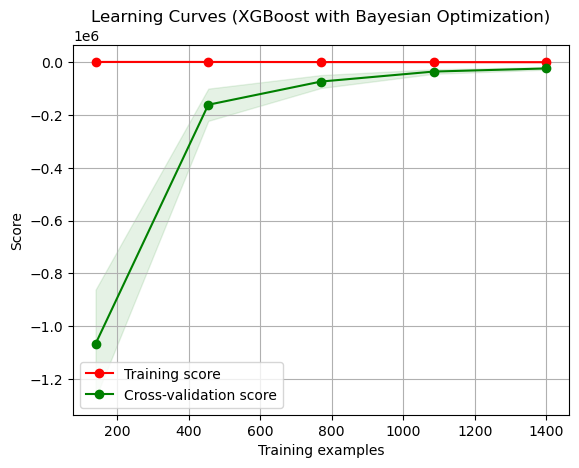

In [264]:
# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (XGBoost with Bayesian Optimization)"
plot_learning_curve(best_model_bayes, title, X_train_scaled, y_train, cv=5, n_jobs=-1)
plt.show()

### Feature Importances

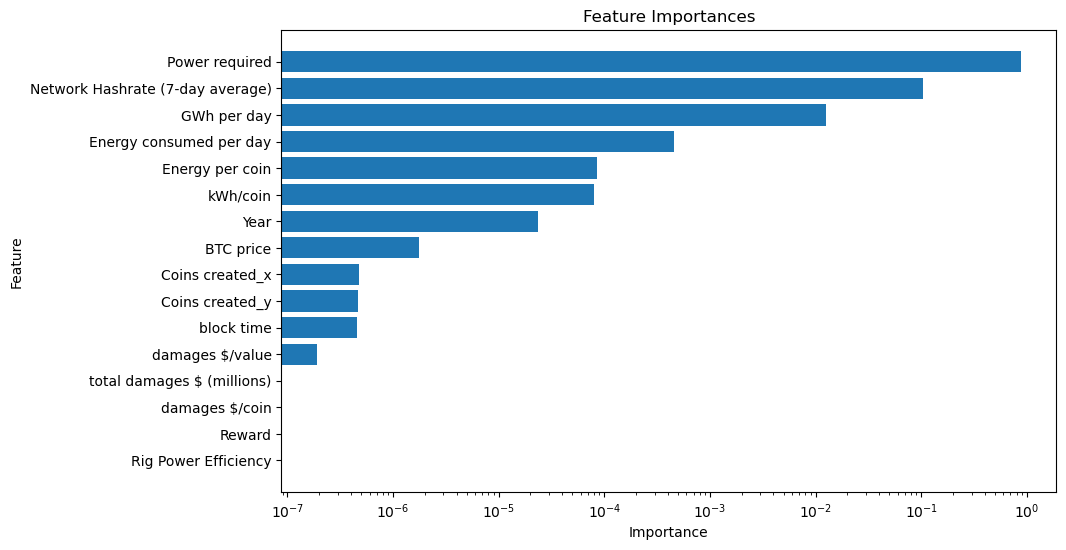

In [278]:
 #Get feature importances
feature_importances = best_model_bayes.feature_importances_

# Create a DataFrame to store feature importances along with their names
feature_importance_df = pd.DataFrame({'Feature': X.columns[:len(feature_importances)], 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xscale('log')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# Set the y-axis limit to include all features

plt.show()